In [143]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [144]:
filename = '../output/CLEAN_2019-06-27 15:19:48.066376'
df = pd.read_csv(filename+'.csv')

# Display all columns in preview
pd.set_option('display.max_columns', 25)
df.head(1)

,address,bedrooms,building_sqft,desc,garages,img_url,list_price,list_status,list_url,lot_sqft,mls_num,pool,real_comp_link,real_comp_name,real_link,real_name,stories,unknown_data,year_built,zipcode,full_baths,half_baths,garage_type
0,"14619 Forest Lodge Drive, Houston, TX 77070",4.0,2712.0,"Single-Family Property, Traditional Style in ...",2,https://photos.harstatic.com/174739766/lr/img-...,259888,For Sale,http://www.har.com/14619-forest-lodge-drive/sa...,8080.0,68979419,No Private Pool,http://www.har.com/re_max-fine-properties/brok...,RE/MAX Fine Properties,http://www.har.com/dionne-randle/agent_DRAN,Dionne Randle,2.0,NaN,1983.0,77070,2,1,Detached


# View Columns

In [145]:
df.columns

Index(['address', 'bedrooms', 'building_sqft', 'desc', 'garages', 'img_url',
       'list_price', 'list_status', 'list_url', 'lot_sqft', 'mls_num', 'pool',
       'real_comp_link', 'real_comp_name', 'real_link', 'real_name', 'stories',
       'unknown_data', 'year_built', 'zipcode', 'full_baths', 'half_baths',
       'garage_type'],
      dtype='object')

# Define Possible Model Features
Feature to predict
    1. Target: List Price
Interval (range of values belongs on a consistent scale, such as temperature)
    2. Interval Data: Building Sqft, Year Built
Discrete, whole number data (no negatives).
    3. Count Features: Bedrooms, Garages, Stories, Full Baths, Half Baths 
Categorical (Nominal or Ordinal)
    4. Categorical Features: Zipcode, List Status, Garage Type
    5. Ordinal Features: N/A
Binary Featuers (Either or choice)
    6. Binary Features: Pool 
Other Features Types
    7. Image Featuers: Image URL
    8. Time Series Features: N/A
    9. Text Features: Description
    10. Useless Features: Address (unless mapped to lat/long), List URL, MLS number, agent name, agent link, agent company name, agent company link, Unknown data (acres)
    
Note: Lot sqft not available for most homes and therefore not included.  Also, additional realtor information could be included (some agents or companies may list homes higher than other companies).  This will not be explored on first pass.

### Final Features Chosen
1. Building Sqft
2. Bedrooms
2. Garages
3. Stories
4. Full Baths
5. Half Baths
6. Zip Codes
7. List Status
8. Pool
9. Year Built

---
Type of Problem: Regression (continuous value target)

Input Shape:
Number of Layers:
Activation Function:
Final Activation Function:



# Prepare DF datatypes

In [146]:
# Create dataframe of only desired features
df_model = (df[['list_price',
                'building_sqft',
                'bedrooms',
                'garages',
                'stories',
                'full_baths',
                'half_baths',
                'zipcode',
                'list_status',
                'pool',
                'year_built']])

# View datatypes to adjust as needed
print(df_model.dtypes)

# Replace private pool vs. no private pool with 0 or 1
df_model.pool.replace(('Has Private Pool', 'No Private Pool'),(1,0), inplace=True)

# Cast list status to categorical datatype
df_model.list_status = pd.Categorical(df_model.list_status)
df_model.list_status = df_model.list_status.cat.codes

# One-hot-encode zipcode
df_zip_hot = pd.get_dummies(df_model.zipcode)
# Drop original zipcode column
df_model.drop(columns='zipcode', inplace=True)
# Add one-hot-encoded zipcode columns
df_model = pd.concat([df_model, df_zip_hot], axis=1)

# Sanity Check
df_model.head()

list_price         int64
building_sqft    float64
bedrooms         float64
garages            int64
stories          float64
full_baths         int64
half_baths         int64
zipcode            int64
list_status       object
pool              object
year_built       float64
dtype: object


/Library/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,list_price,building_sqft,bedrooms,garages,stories,full_baths,half_baths,list_status,pool,year_built,77003,77004,...,77090,77091,77092,77093,77094,77095,77096,77098,77099,77339,77345,77489
0,259888,2712.0,4.0,2,2.0,2,1,0,0,1983.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,259883,2318.0,4.0,2,2.0,2,1,0,0,2016.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,259840,1864.0,4.0,2,1.0,2,0,2,0,2019.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
3,259635,2785.0,4.0,2,2.0,2,1,2,0,2019.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,259500,3259.0,4.0,2,2.0,3,1,0,0,2005.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


# Split into Train/Test/Validation Datasets

In [147]:
# Split data into 90% training and 10% testing
train, test = train_test_split(df_model, test_size=0.1, random_state=42)
# Of the 90% training data, split again to 10% validation
train, val = train_test_split(train, test_size=0.1, random_state=42)

# Results are still a pandas dataframe
print(len(train), 'training examples')
print(len(test), 'testing examples')
print(len(val), 'validation examples')

8245 training examples
1019 testing examples
917 validation examples


# Scale Labels 0-1 for All Datasets

In [148]:
# Split labels from features
train_labels = train.list_price 
train = train.drop(columns='list_price', axis=1)

test_labels = test.list_price
test = test.drop(columns='list_price', axis=1)

val_labels = val.list_price
val = val.drop(columns='list_price', axis=1)

# Scale list price 0 - 1
max_price = train_labels.max()
train_labels = train_labels.map(lambda x: x/max_price)
test_labels = test_labels.map(lambda x: x/max_price)
val_labels = val_labels.map(lambda x: x/max_price)

# Sanity Check - Are list price values between 0-1
print(f'Train Label Min: {train_labels.min()}')
print(f'Train Label Max: {train_labels.max()}')
print(f'Test Label Min: {test_labels.min()}')
print(f'Test Label Max: {test_labels.max()}')
print(f'Val Label Min: {val_labels.min()}')
print(f'Val Label Max: {val_labels.max()}')

Train Label Min: 0.025
Train Label Max: 1.0
Test Label Min: 0.045
Test Label Max: 1.0
Val Label Min: 0.0399
Val Label Max: 1.0


# Scale Continuous Features Based on Training Set Distribution

In [149]:
# Define continuous columns for scaling
continuous_columns = ['bedrooms','garages','stories','full_baths','half_baths','building_sqft','year_built']

# Perform normalization in place on all continuous features for 
# training/testing/validation sets based on distribution of training set
scaler = MinMaxScaler()
train[continuous_columns] = scaler.fit_transform(train[continuous_columns])
test[continuous_columns] = scaler.transform(test[continuous_columns])
val[continuous_columns] = scaler.transform(val[continuous_columns])

# Sanity Check - are values between 0-1 for continuous columns? 
# Excluding zipcodes for display...
print(f'Train Shape: {train.shape}')
print(f'Train Min: {train.iloc[:,0:9].min()}')
print(f'Train Max: {train.iloc[:,0:9].max()}')
print(f'Test Shape: {test.shape}')
print(f'Test Min: {test.iloc[:,0:9].min()}')
print(f'Test Max: {test.iloc[:,0:9].max()}')
print(f'Val Shape: {val.shape}')
print(f'Val Min: {val.iloc[:,0:9].min()}')
print(f'Val Max: {val.iloc[:,0:9].max()}')

Train Shape: (8245, 98)
Train Min: building_sqft    0.0
bedrooms         0.0
garages          0.0
stories          0.0
full_baths       0.0
half_baths       0.0
list_status      0.0
dtype: float64
Train Max: building_sqft    1.0
bedrooms         1.0
garages          1.0
stories          1.0
full_baths       1.0
half_baths       1.0
list_status      3.0
dtype: float64
Test Shape: (1019, 98)
Test Min: building_sqft    0.014592
bedrooms         0.000000
garages          0.000000
stories          0.000000
full_baths       0.000000
half_baths       0.000000
list_status      0.000000
dtype: float64
Test Max: building_sqft    0.489771
bedrooms         0.625000
garages          1.000000
stories          0.750000
full_baths       0.625000
half_baths       0.555556
list_status      3.000000
dtype: float64
Val Shape: (917, 98)
Val Min: building_sqft    0.009657
bedrooms         0.000000
garages          0.000000
stories          0.000000
full_baths       0.000000
half_baths       0.000000
list_st

# Convert to Numpy

We now have ideally formatted and scaled features and labels in a pandas dataframe.  We'll convert all data to numpy for easier processing with Keras/Tensorflow


In [150]:
# Convert pandas dataframes to numpy arrays
train = train.values
test = test.values
val = val.values

train_labels = train_labels.values
test_labels = test_labels.values
val_labels = val_labels.values

# Sanity check.  Are we working with numpy arrays now?
print(type(train))

<class 'numpy.ndarray'>


# Develop Baseline
### Linear Regression

In [151]:
# Create/Train model
lin_reg = LinearRegression()
lin_reg.fit(train, train_labels)

# Make Predicitons and evaluate
lin_p = lin_reg.predict(test)

# Calculate the difference between the predicted list price and 
# the actual list price for each property
diff = lin_p.flatten()-test_labels
percent_diff = (diff / test_labels) * 100
abs_perc_diff = np.abs(percent_diff)

# mean of absolute percent diff
mean = np.mean(abs_perc_diff)
# std of absolute percent diff
std = np.std(abs_perc_diff)

print(f'Linear Regression Average Absolute Percentage Difference (Error): {mean}')
print(f'Linear Regression Average Absolute Standard Deviation: {std}')

Linear Regression Average Absolute Percentage Difference (Error): 19.76382617386798
Linear Regression Average Absolute Standard Deviation: 23.24913476971067


### Random Forest

In [152]:
# Create/Train model
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf_reg.fit(train,train_labels)

# Make Predictions and evaluate
rf_reg_pred = rf_reg.predict(test)

# Calculate the difference between the predicted list price and 
# the actual list price for each property
diff = rf_reg_pred.flatten()-test_labels
percent_diff = (diff / test_labels) * 100
abs_perc_diff = np.abs(percent_diff)

# mean of absolute percent diff
mean = np.mean(abs_perc_diff)
# std of absolute percent diff
std = np.std(abs_perc_diff)

print(f'Random Forest Average Absolute Percentage Difference (Error): {mean}')
print(f'Random Forest Average Absolute Standard Deviation: {std}')

Random Forest Average Absolute Percentage Difference (Error): 16.621493610901194
Random Forest Average Absolute Standard Deviation: 22.34068480867122


In [153]:
# This block does not work properly.  Running the plot interferes with the Keras
# .fit() method.  Still in the process of tracking down the bug.

rf_importance = rf_reg.feature_importances_
new_df = pd.DataFrame(columns=['features','importance'])
new_df.features = list(df_model.columns[1:])
new_df.importance = rf_importance
new_df.sort_values(by='importance', 
                   inplace=True, 
                   ascending=False)

# new_df = new_df[new_df.importance >= 0.025]
# test = sns.catplot(x='features',
#                    y='importance',
#                    data=new_df, 
#                    kind='bar',
#                    height=7)

# plt.xticks(rotation=45);
# plt.clf()
# plt.close()

# Build the Model

In [154]:
# Input dimension shape should be defined as the number of features (columns) in the input array
model=Sequential()
model.add(Dense(8, input_dim=train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

# Define Optimizer (consider adding decay, switching to Adam, etc.)
adam = optimizers.Adam(lr=1e-3, decay=1e-3/300)

# Compile model
model.compile(loss='mean_absolute_percentage_error', optimizer=adam)

# Train the Model (and record the history)

In [155]:
hist = model.fit(train, 
                 train_labels, 
                 validation_data=(test, test_labels), 
                 epochs=300, 
                 batch_size=32, 
                 verbose=1)

Train on 8245 samples, validate on 1019 samples
Epoch 1/300
8245/8245 [==============================] - 4s 480us/step - loss: 35.7864 - val_loss: 24.1366
Epoch 2/300
8245/8245 [==============================] - 1s 121us/step - loss: 22.2065 - val_loss: 20.6394
Epoch 3/300
8245/8245 [==============================] - 1s 123us/step - loss: 20.1760 - val_loss: 19.3781
Epoch 4/300
8245/8245 [==============================] - 1s 131us/step - loss: 19.1956 - val_loss: 18.4144
Epoch 5/300
8245/8245 [==============================] - 1s 124us/step - loss: 18.5302 - val_loss: 17.8765
Epoch 6/300
8245/8245 [==============================] - 1s 125us/step - loss: 18.0356 - val_loss: 17.5812
Epoch 7/300
8245/8245 [==============================] - 1s 134us/step - loss: 17.7178 - val_loss: 17.1576
Epoch 8/300
8245/8245 [==============================] - 1s 124us/step - loss: 17.4076 - val_loss: 17.0914
Epoch 9/300
8245/8245 [==============================] - 1s 132us/step - loss: 17.1784 - val_los

# Make Predictions on Testing Data

In [156]:
# Use the trained model to predict a list price for each property
p = model.predict(test)

# Calculate the difference between the predicted list price and 
# the actual list price for each property
diff = p.flatten()-test_labels
percent_diff = (diff / test_labels) * 100
abs_perc_diff = np.abs(percent_diff)

# mean of absolute percent diff
mean = np.mean(abs_perc_diff)
# std of absolute percent diff
std = np.std(abs_perc_diff)

print(f'Mean Absolute Percent List Price Difference: {mean}')
print(f'Standard Deviation of Percent List Price Difference {std}')

Mean Absolute Percent List Price Difference: 14.592530856620227
Standard Deviation of Percent List Price Difference 14.266279838192796


# Plot Model Loss

In [157]:
# View history object options
print(hist.history.keys())

dict_keys(['val_loss', 'loss'])


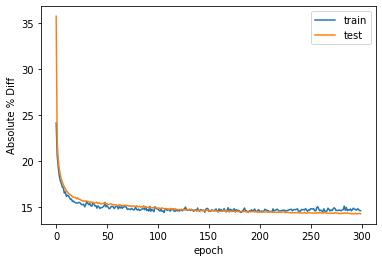

In [158]:
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])
plt.xlabel('epoch') 
plt.ylabel('Absolute % Diff')
plt.legend(['train','test'])
plt.show()

# Cross Validate with Validation Set

In [159]:
# Use the trained model to predict a list price for each property
p = model.predict(val)

# Calculate the difference between the predicted list price and 
# the actual list price for each property
diff = p.flatten()-val_labels
percent_diff = (diff / val_labels) * 100
abs_perc_diff = np.abs(percent_diff)

# mean of absolute percent diff
mean = np.mean(abs_perc_diff)
# std of absolute percent diff
std = np.std(abs_perc_diff)

print(f'Mean Absolute Percent List Price Difference: {mean}')
print(f'Standard Deviation of Percent List Price Difference {std}')

Mean Absolute Percent List Price Difference: 16.258952215608286
Standard Deviation of Percent List Price Difference 17.613698127795534


#### Possibly some overfitting?